In [1]:
## These program is was created as result and requisite of the coursera course
##
##     Advanced Data Science with IBM   
##
####################################################################
## The main objective on this program is create a Demand Planing ML model
## for this we took the data set from kaggle called future Volume Prediction
## https://www.kaggle.com/utathya/future-volume-prediction
## The outcome is a model to predict the volume of future months.
####################################################################
##
##    Feature creation
##

In [1]:
from IPython import get_ipython
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from numpy import array
#from numpy import hstack
from math import sqrt
#from numpy import concatenate

In [2]:
# Libraries to use for Feacture Selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Libraries to use for Accuracy on Feacture Selection
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate,  cross_val_score

In [3]:
# Read the dataset storaged on the previous File
dataset = pd.read_csv('dataset.csv')
df =dataset.copy()

In [4]:
#Indexing YearMonth
dataset.set_index('YearMonth',inplace=True)
#Separating X and y 
y = dataset['Volume']
X = dataset.drop(columns=['Volume'])


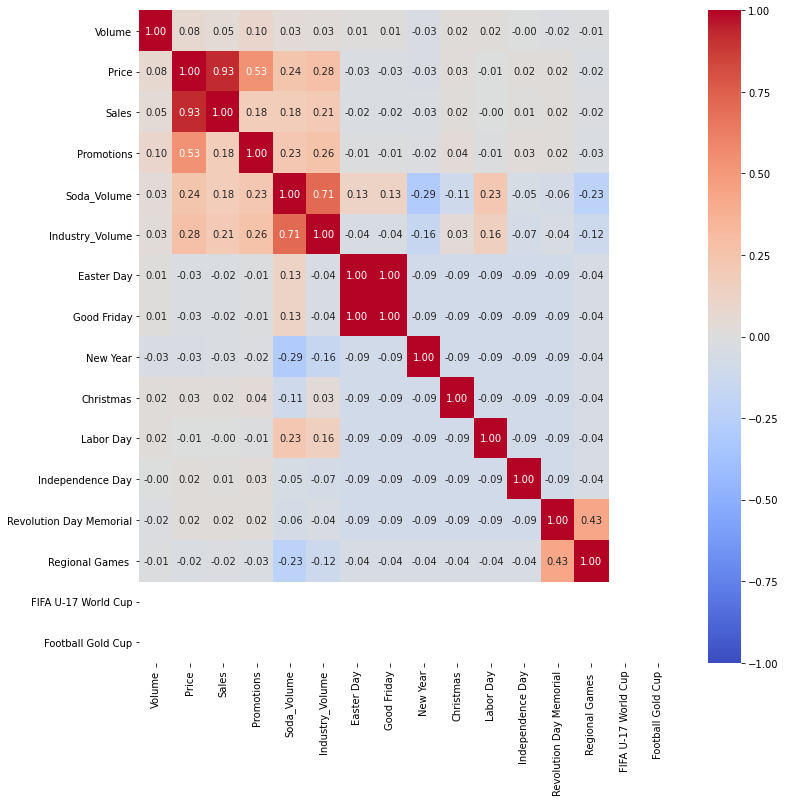

In [5]:
import seaborn as sns
# Creating a Correlation Matix for the  data and plotting a Heat Map.
corr = dataset[dataset.columns[:18]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,vmin=-1,cmap='coolwarm', annot=True, fmt = ".2f")
plt.show()

In [6]:
# Dropping world cup and gold cup. Not relevant field
X =  X.drop(columns =['FIFA U-17 World Cup', 'Football Gold Cup'])
# removing Sales high correlacion with price. Not relevant field
X = X.drop(columns=['Sales'])

In [7]:
#Showing the 3 Top SKU x Volume.
df_sku=[]
df_sku = df[['SKU', 'Volume']]
df_sku = df_sku.groupby(['SKU']).sum()
skus=df_sku.sort_values(by=['Volume'],ascending=False).head(3)
skus

,Volume
SKU,
SKU_01,9.965440e+06
SKU_02,6.890135e+06
SKU_03,6.312349e+06


In [8]:
# preparing Data
# Coverting the categorical SKU to Dummy 
X = pd.get_dummies(X, columns= ['SKU'], dummy_na= False)

In [10]:
X.head()

,Agency,Price,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,...,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_22,1168.903668,99.737475,718394219,492612703,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,1167.000000,99.742500,718394219,492612703,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_58,0.000000,0.000000,718394219,492612703,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2013-01-01,Agency_48,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,1310.176057,106.300346,718394219,492612703,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Normailizingand Scaling  the Data.
std_call = ['Price', 'Promotions', 'Soda_Volume','Industry_Volume', 'Avg_Max_Temp', 'Avg_Population_2017','Avg_Yearly_Household_Income_2017']
scaller = StandardScaler()
std = pd.DataFrame(scaller.fit_transform(X[std_call]),columns=std_call)
X_std=X.copy()
X_std = X_std.drop(columns=['Agency'])
X_std.loc[:,std_call] = std.values

In [12]:
# Split train and test data set.
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 217,shuffle=True)

In [13]:
## Function created to evaluar process different regressor models for a train set
## This use cross validate of each model and storage in a data frame as output
## input( X_train data set as a Data Frame,  Y_train data set as a Data Frame )
## output(results as Data Frame ); results provide the fit tie, score_time, R_2, mse and mae)
# I took the idea from this web page. I convert it to function.
# https://www.kaggle.com/zonnalobo/volume-forecasting-sku-recommendations
def cross_val_mydata(X_train,y_train):
    models = []
    # Load the Models.
    models.append(('RF', RandomForestRegressor()))
    models.append(('LR', LinearRegression()))
    models.append(('GB', GradientBoostingRegressor()))
    models.append(('LG', LGBMRegressor()))
    models.append(('KN', KNeighborsRegressor()))
    models.append(('XG', XGBRegressor(objective='reg:squarederror')))
    # create the storage data frame
    results = pd.DataFrame({'Score':['fit_time', 'score_time', 'test_R_Square', 'test_MSE', 'test_MAE', 'test_RMSE']})
    # Loop to run all models.
    for name, model in models:
        # Spot all scorers want to be used
        # R2 Score Best Possible is 100.
        # mae, mse and rmse the best possible is 0
        scorer = {'R_Square' : 'r2',
                'MSE'  : 'neg_mean_squared_error',
                'MAE' :  'neg_mean_absolute_error',
                'RMSE' : 'neg_root_mean_squared_error' }
        # Cross Validation Model
        kfold = KFold(n_splits=5, random_state=217,shuffle=True)
        cv_results = cross_validate(model,X_train, y_train,cv=kfold,scoring=scorer)
        cv_results['test_R_Square'] = cv_results['test_R_Square']*100
        cv_results['test_RMSE'] = np.abs(cv_results['test_RMSE'])
        cv_results['test_MSE'] = np.abs(cv_results['test_MSE'])
        cv_results['test_MAE'] = np.abs(cv_results['test_MAE'])
        results[name] = pd.DataFrame(cv_results).mean().values
    return results

In [ ]:
# function to plot feature importance. I took it from this web page
# https://www.kaggle.com/zonnalobo/volume-forecasting-sku-recommendations
def plot_feature_importances(df,n):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (12, 12))
    ax = plt.subplot()
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances RF')
    plt.show()
    return df

In [14]:
### Showing the results GB has the mest mse, mae and rmse while RF has the vest R_2
results = cross_val_mydata(X_train,y_train)
results

,Score,RF,LR,GB,LG,KN,XG
0,fit_time,8.748250,2.547517e-02,2.310432e+00,0.282952,7.343073e-02,1.400898
1,score_time,0.104906,6.130314e-03,1.174669e-02,0.010767,8.136951e-01,0.019245
2,test_R_Square,96.191035,4.144872e+01,7.083398e+01,94.226693,6.239233e+01,94.977495
3,test_MSE,274089.013102,4.226678e+06,2.102227e+06,415017.348477,2.710468e+06,360996.220907
4,test_MAE,215.132419,1.305205e+03,8.043749e+02,328.414532,7.928438e+02,314.651045
5,test_RMSE,523.152938,2.054369e+03,1.449479e+03,644.030229,1.645641e+03,600.669216


In [14]:
# Taking RF as the best performer metrics using R_square
model = RandomForestRegressor()
model.fit(X_std, y)

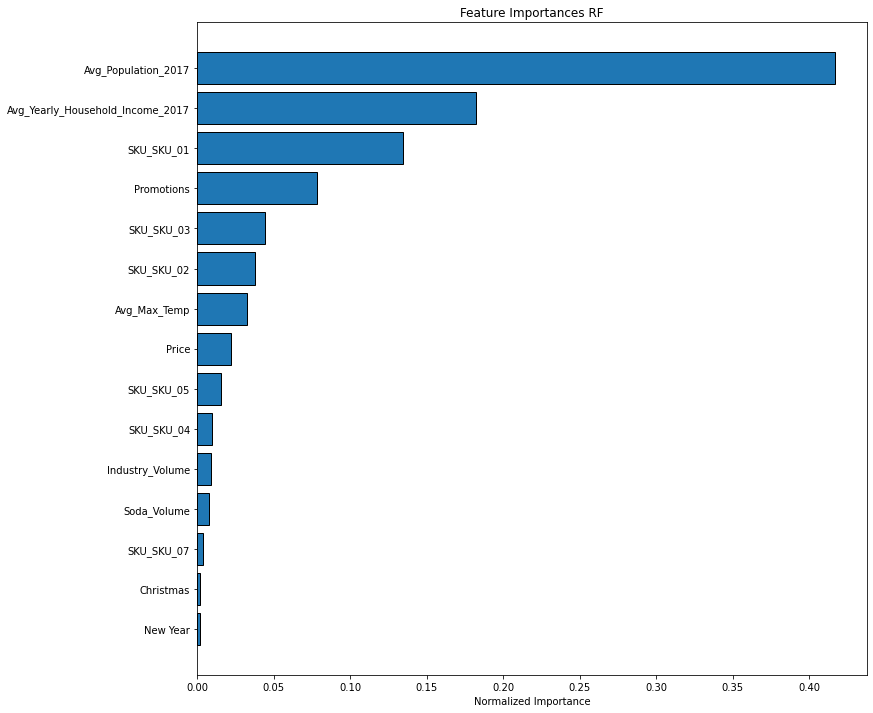

In [15]:
# Extract feature importances using RF
# Using RF Avg_pupulation_2017, Avg_yearly_Household Income, Promotions and Ave_max Temp are important features
# Products SKU_01, SKU_02 and SKU_03 are the must relevant
x_call = X_std.columns
feature_importance = model.feature_importances_
feature_importances = pd.DataFrame({'feature': x_call, 'importance': feature_importance})
feature_importance = plot_feature_importances(feature_importances,15)

In [15]:
# Extract feature importances using RGB
# Using RF Avg_pupulation_2017, promotions, Avg_yearly_Household Income, price are important features
# Products SKU_01, SKU_02 and SKU_03 are the must relevant
model = GradientBoostingRegressor()
model.fit(X_std, y)

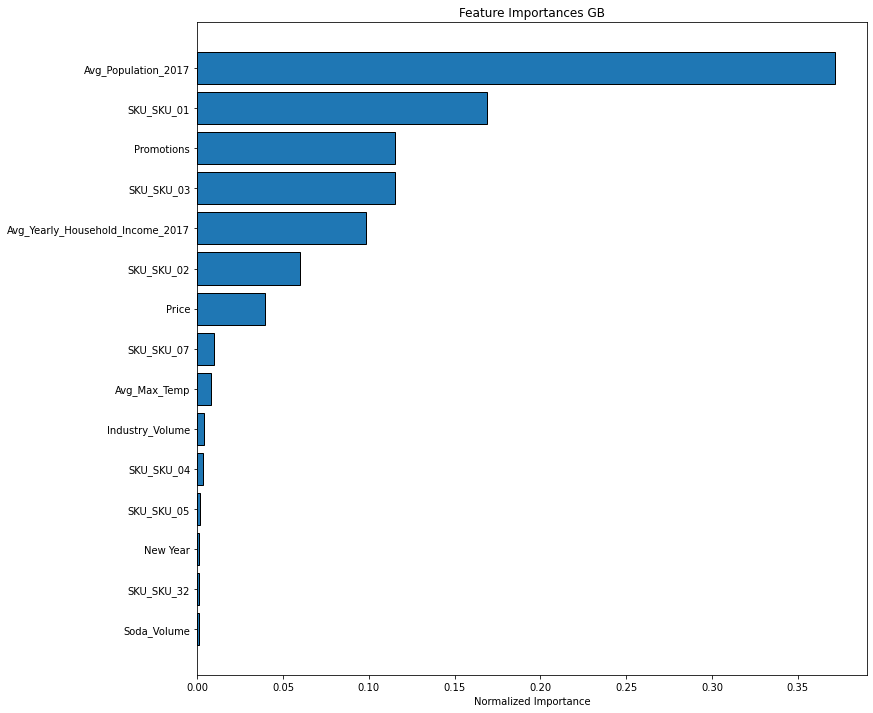

In [16]:
# Extract feature importances
x_call = X_std.columns
feature_importance = model.feature_importances_
feature_importances = pd.DataFrame({'feature': x_call, 'importance': feature_importance})
feature_importance = plot_feature_importances(feature_importances,15)

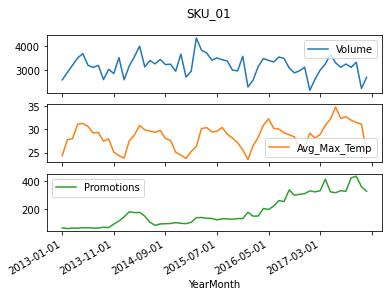

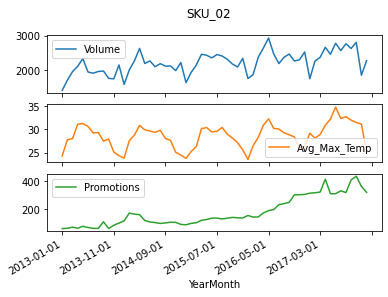

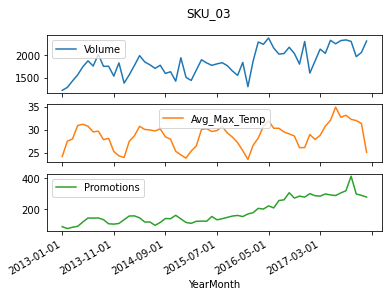

In [17]:
# Exploring Feature importance data for the top 3
# as 
for sku in skus.index:
    df_sku = df[['SKU', 'Volume', 'Avg_Max_Temp', 'Promotions']]
    df_sku = df_sku.groupby(['SKU']).sum()
    df_sku_sel = df[df['SKU'] == sku][['YearMonth','Volume', 'Avg_Population_2017', 'Avg_Max_Temp', 'Promotions']]
    df_sku_sel = df_sku_sel.groupby(['YearMonth']).agg({ 'Volume': np.mean, 'Avg_Max_Temp' : np.mean, 'Promotions': np.mean })
    df_sku_sel.plot(subplots=True, title = sku )
